In [ ]:
# install kneed
!pip install --upgrade kneed

In [1]:
#insert all packages needed
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from kneed import KneeLocator

In [2]:
#import the smiles list
file_name = r"tested_molecules-1.csv"
with open(file_name, "r") as ins:
    smiles = []
    for line in ins:
        smiles.append(line.split('\n')[0])
print('# of SMILES:', len(smiles))

# of SMILES: 1001


In [3]:
#split the csv file into multiple columns
#read the dataframe
df_molecules = pd.read_csv(file_name)

# #split the csv file into multiple columns
# #read the dataframe
df_molecules = pd.read_csv(file_name)

# #split the dataframe
new_columns = df_molecules['SMILES;ALDH1_inhibition'].str.split(';', expand=True)
df_molecules = pd.concat([df_molecules, new_columns], axis=1)

# #drop the original column
df_molecules = df_molecules.drop('SMILES;ALDH1_inhibition', axis=1)

# #rename the column names 
df_molecules = df_molecules.rename(columns={0:'SMILES',1:'ALDH1_inhibition'})

df_molecules


,SMILES,ALDH1_inhibition
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,1
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,1
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,1
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,1
4,CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21,1
...,...,...
995,COc1ccc(N2C(=O)CC([NH2+]C3CC3)C2=O)cc1,0
996,CCNc1oc(COc2cccc(C)c2)nc1C#N,0
997,NC(=O)Cn1cnc(-c2ccccc2)c1,0
998,Cc1cc(NC(=O)CSc2nc3c(c(=O)n(C)c(=O)n3C)n2C(C)C...,0


In [4]:
#since the list is very large, to try stuff out, we look at the first 4 smiles
only_smiles_list = df_molecules['SMILES']

smiles_tryout = only_smiles_list
smiles_tryout;

In [5]:
#draw the four mole images
mols = [Chem.MolFromSmiles(smi) for smi in smiles_tryout]
#Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(200, 200))

In [6]:
#calculate descriptor list
desc_list = [n[0] for n in Descriptors._descList]
#print(len(desc_list))
#print(desc_list)

In [7]:
#calculate molecular descriptors and make them floats
calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_list)

rdkit_desc_data = [calc.CalcDescriptors(m) for m in mols]

rdkit_desc = []
for element in rdkit_desc_data:   
    tuple_floats = tuple(float(x) for x in element)
    rdkit_desc.append(tuple_floats)
    
#print(rdkit_desc_data[0])
#print(rdkit_desc[0])

In [8]:
#add columns to dataframe
for col in range(len(desc_list)):
    column = []
    for row in range(len(rdkit_desc)):
        #the row iteration is for the molecule and the col iteration for the descriptor, this makes a list which will be
        #added to the dataframe
        descriptor = rdkit_desc[row][col]
        column.append(descriptor)
    df_molecules[desc_list[col]] = column
df_molecules = df_molecules.drop(columns=['fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea'])

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
df_molecules

C:\Users\20213656\AppData\Local\Temp\ipykernel_19104\4235133025.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_molecules[desc_list[col]] = column
C:\Users\20213656\AppData\Local\Temp\ipykernel_19104\4235133025.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_molecules[desc_list[col]] = column
C:\Users\20213656\AppData\Local\Temp\ipykernel_19104\4235133025.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

,SMILES,ALDH1_inhibition,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,...,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,1,13.083531,13.083531,0.001173,-0.683140,0.520365,463.542,434.310,463.233188,178.0,0.0,0.249868,-0.496477,0.496477,0.249868,1.088235,1.794118,2.500000,16.465857,10.012387,2.277377,-2.329164,2.213373,-2.524368,5.869762,-0.128181,3.345650,1.374647,1110.519072,23.915638,19.347200,19.347200,16.546045,11.329861,11.329861,8.265229,8.265229,5.888540,5.888540,4.187622,4.187622,-3.95,6.958111e+07,23.216344,10.778358,5.506759,197.833708,20.270350,11.791353,...,64.304606,16.009896,0.000000,25.328832,54.597304,0.000000,5.687386,0.0,114.27,6.041841,9.589074,0.0,17.856200,31.208186,24.092481,6.923737,11.791600,54.597304,31.058939,4.736863,7.122812,0.000000,26.972964,18.075462,1.758225,0.920982,16.565369,1.837103,2.822263,1.591488,0.375000,34.0,2.0,10.0,0.0,1.0,1.0,2.0,1.0,3.0,8.0,2.0,10.0,8.0,0.0,1.0,1.0,4.0,1.50330,126.8344
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,1,12.170097,12.170097,0.066966,-0.066966,0.498564,378.457,360.313,378.115047,136.0,0.0,0.230353,-0.467476,0.467476,0.230353,1.111111,2.000000,2.814815,32.166556,10.202245,2.140429,-2.083839,2.235385,-2.240774,7.993662,-0.118316,3.338816,1.485090,1028.775024,18.476481,14.538559,15.355056,13.292826,8.564791,9.550390,5.957024,6.899523,4.024513,5.000911,2.736403,3.568412,-3.06,3.137659e+06,17.358644,8.092317,4.199706,160.174276,9.733940,11.276948,...,26.195090,17.884050,0.000000,11.323699,76.630898,0.000000,11.163878,0.0,72.95,0.000000,4.794537,0.0,11.660033,13.089513,27.644013,11.761885,18.526374,36.398202,31.984579,4.417151,7.276561,1.406535,21.295170,3.630481,2.804024,0.940073,17.587352,3.352383,1.040755,0.000000,0.150000,27.0,1.0,6.0,0.0,0.0,0.0,1.0,3.0,4.0,6.0,1.0,7.0,7.0,0.0,0.0,0.0,4.0,3.48110,104.3507
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,1,10.905837,10.905837,0.016881,-0.016881,0.382043,477.589,444.325,477.260865,184.0,0.0,0.219930,-0.492903,0.492903,0.219930,1.228571,2.114286,2.857143,16.492058,9.989823,2.359046,-2.317898,2.246545,-3.124535,5.824876,-0.951912,3.598320,1.509009,1263.581781,24.363232,20.515922,20.515922,16.991204,12.321269,12.321269,9.787693,9.787693,6.864949,6.864949,5.211578,5.211578,-3.30,1.436707e+08,23.442266,10.131417,5.058984,204.265757,19.160451,31.498483,...,49.553366,17.826376,12.841643,55.442513,47.078516,0.000000,10.902925,0.0,103.53,0.000000,5.106527,0.0,23.943702,13.089513,59.607761,4.899910,6.263163,41.937375,40.423272,9.154014,13.395484,0.000000,5.789600,24.674971,2.688982,1.918367,11.911982,3.929994,9.023954,0.000000,0.461538,35.0,2.0,9.0,0.0,1.0,1.0,1.0,3.0,4.0,8.0,2.0,9.0,9.0,0.0,1.0,1.0,5.0,2.83782,129.8585
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,1,11.562446,11.562446,0.270607,-0.454447,0.795948,330.609,317.505,328.981818,96.0,0.0,0.351723,-0.421732,0.421732,0.351

In [9]:
#put all the column names of the dataframe in a list
columns = []
for column in df_molecules:
    columns.append(column)
print(columns)


['SMILES', 'ALDH1_inhibition', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_V

In [10]:
#check the correlations between all columns and put the highest correlations in a list
highcorr=[]
allcorr = []
for column1 in range(len(columns)):
    for column2 in range(len(columns)):
        if column1 != column2 and column1>1 and column2>1 and column2>=column1:
            corr = df_molecules[columns[column1]].corr(df_molecules[columns[column2]])
            #print("Correlation between ", columns[column1], " and ", columns[column2], "is: ", round(corr, 2))
            allcorr.append(corr)
            if corr >= 0.80 or corr <= -0.80:
                #all correlations of 0,9 or higher are put in a list
                highcorr.append([columns[column1],columns[column2],round(corr,2)])
#print(highcorr)
#print(len(highcorr))

In [11]:
#put all the columns with high correlation in a list (except the first ones to have the high correlation like MolWt)
dupe_col = []
for i in range(len(highcorr)):
    if highcorr[i][1] not in dupe_col:
        dupe_col.append(highcorr[i][1])
print(len(dupe_col))

40


In [12]:
for i in dupe_col:    
    df_molecules = df_molecules.drop(columns = [i])
#df_molecules

columns_new = []
for descriptor in df_molecules:
    columns_new.append(descriptor)
print(columns_new)
df_molecules

['SMILES', 'ALDH1_inhibition', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'HallKierAlpha', 'Ipc', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_ESta

,SMILES,ALDH1_inhibition,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,HallKierAlpha,Ipc,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,NHOHCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticHeterocycles,NumAromaticRings,NumSaturatedHeterocycles,RingCount,MolLogP
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,1,13.083531,0.001173,-0.683140,0.520365,463.542,0.0,0.249868,-0.496477,1.088235,16.465857,10.012387,2.277377,-2.329164,2.213373,-2.524368,5.869762,-0.128181,3.345650,1.374647,-3.95,6.958111e+07,20.270350,11.791353,0.000000,17.762699,0.000000,0.000000,9.589074,0.000000,4.681803,0.000000,41.496884,47.030966,32.475912,12.797184,14.325937,17.762699,0.000000,30.840832,0.000000,38.269884,25.099220,60.160755,0.0,11.436898,20.270350,5.948339,5.749512,0.000000,64.304606,16.009896,0.000000,0.000000,5.687386,0.0,114.27,6.041841,9.589074,0.0,17.856200,31.208186,24.092481,6.923737,11.791600,54.597304,31.058939,4.736863,26.972964,18.075462,1.758225,0.920982,1.837103,2.822263,1.591488,0.375000,2.0,0.0,1.0,1.0,1.0,3.0,1.0,4.0,1.50330
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,1,12.170097,0.066966,-0.066966,0.498564,378.457,0.0,0.230353,-0.467476,1.111111,32.166556,10.202245,2.140429,-2.083839,2.235385,-2.240774,7.993662,-0.118316,3.338816,1.485090,-3.06,3.137659e+06,9.733940,11.276948,10.803614,5.907180,0.000000,0.000000,9.361637,9.967957,0.000000,0.000000,42.093720,29.828920,6.196844,25.105529,9.211688,28.832943,0.000000,19.851845,0.000000,18.245949,5.752854,78.381009,0.0,0.000000,5.316789,0.000000,0.000000,11.761885,26.195090,17.884050,0.000000,0.000000,11.163878,0.0,72.95,0.000000,4.794537,0.0,11.660033,13.089513,27.644013,11.761885,18.526374,36.398202,31.984579,4.417151,21.295170,3.630481,2.804024,0.940073,3.352383,1.040755,0.000000,0.150000,1.0,0.0,0.0,0.0,3.0,4.0,0.0,4.0,3.48110
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,1,10.905837,0.016881,-0.016881,0.382043,477.589,0.0,0.219930,-0.492903,1.228571,16.492058,9.989823,2.359046,-2.317898,2.246545,-3.124535,5.824876,-0.951912,3.598320,1.509009,-3.30,1.436707e+08,19.160451,31.498483,6.041841,11.704393,0.000000,0.000000,0.000000,9.665781,0.000000,5.098682,32.046576,53.954703,17.911012,17.343315,19.160451,10.902925,0.000000,25.191233,5.917906,58.848175,13.151638,65.372920,0.0,5.879988,4.899910,0.000000,5.879988,0.000000,49.553366,17.826376,12.841643,0.000000,10.902925,0.0,103.53,0.000000,5.106527,0.0,23.943702,13.089513,59.607761,4.899910,6.263163,41.937375,40.423272,9.154014,5.789600,24.674971,2.688982,1.918367,3.929994,9.023954,0.000000,0.461538,2.0,0.0,1.0,1.0,3.0,4.0,1.0,5.0,2.83782
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,1,11.562446,0.270607,-0.454447,0.795948,330.609,0.0,0.351723,-0.421732,1.333333,79.918731,10.173315,2.116608,-2.205938,2.302152,-2.211289,9.103314,0.556316,2.372515,2.658955,-1.00,1.207136e+04,9.317061,10.055740,0.000000,0.000000,0.000000,5.625586,0.000000,4.794537,0.000000,0.000000,11.600940,41.910152,30.229490,5.022633,4.417151,44.187514,0.000000,0.000000,0.000000,13.847474,17.989423,38.114578,0.0,0.000000,10.525496,5.687386,0.000000,27.530884,13.089513,0.000000,0.000000,5.022633,10.969244,0.0,33.45,5.625586,4.794537,0.0,4.472720,10.605653,24.163123,0.000000,0.000000,18.199101,34.677328,16.01

## Remove outliers 

In [13]:
def find_outliers(df, column):
    q1=df[column].quantile(0.05)
    q3=df[column].quantile(0.95)
    IQR=q3-q1
    lower_outliers = df[column][(df[column]<(q1-IQR))]
    upper_outliers = df[column][(df[column]>(q3+IQR))]
    frames = [lower_outliers, upper_outliers]
    outliers = pd.concat(frames)
    #print(outliers)
    return outliers


In [14]:
def remove_outliers(df, columns):
    df_removed = pd.DataFrame()
    for column in columns:
        outliers = find_outliers(df, column)
        df_outliers = pd.DataFrame.from_dict(outliers)
        list_indexes_outliers = list(df_outliers.index.values)
        df_column = df.filter([column], axis=1)
        for i in range(len(list_indexes_outliers)):
            index_to_drop = list_indexes_outliers[i]
    #         df_column.drop(index_to_drop)
            df_column[column][index_to_drop] = np.NaN
        df_removed[column] = df_column[column]
    return df_removed

In [15]:
#maall descriptors
scaler = MinMaxScaler()
scaled_df = df_molecules.copy()

descriptors = ['MaxAbsEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'MolWt', 'NumRadicalElectrons',
       'MaxPartialCharge', 'MinPartialCharge', 'FpDensityMorgan1',
       'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO',
       'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
       'AvgIpc', 'BalabanJ', 'HallKierAlpha', 'Ipc', 'PEOE_VSA1', 'PEOE_VSA10',
       'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2',
       'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2',
       'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8',
       'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12',
       'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA7', 'SlogP_VSA8',
       'SlogP_VSA9', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11',
       'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5',
       'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9',
       'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5',
       'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3',
       'NHOHCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles',
       'NumAliphaticRings', 'NumAromaticHeterocycles', 'NumAromaticRings',
       'NumSaturatedHeterocycles', 'RingCount','MolLogP']

#create copy of molecules df without the outliers

#no_outliers_df = df_molecules.copy()


#pd.set_option('display.max_rows', 1000)
#for descriptor in descriptors:
    #no_outliers_df[descriptor]=remove_outliers(df_molecules, descriptor)
no_outliers_df = remove_outliers(df_molecules,descriptors)
#no_outliers_df
#print(no_outliers_df)
#no_NaN_df = no_outliers_df.dropna(inplace=True)
#print(no_NaN_df)
duplicate_rows = no_outliers_df.duplicated()

for x in duplicate_rows:

    if x==True:
        print('There are duplicating rows')
        
if x == False:
    print('There are no duplicating rows')

There are no duplicating rows


### Check the distribution

In [16]:
#Scaling the dataframe
for column in descriptors:
    scaled_df[column] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(no_outliers_df[column])),columns=[column])
scaled_df

,SMILES,ALDH1_inhibition,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,HallKierAlpha,Ipc,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,NHOHCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticHeterocycles,NumAromaticRings,NumSaturatedHeterocycles,RingCount,MolLogP
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,1,0.883077,0.001174,0.732144,0.492906,0.688495,0.0,0.391821,0.420463,0.433017,0.084394,0.519947,0.399564,0.438110,0.421380,0.451215,0.233313,0.311044,0.811612,0.178216,0.184564,0.921100,0.482531,0.319370,0.000000,0.739676,0.000000,0.000000,0.277948,0.000000,0.241398,0.000000,0.402306,0.475187,0.641177,0.222241,0.326658,0.254207,0.0,0.767100,0.000000,0.371621,0.339863,0.479709,0.0,0.389011,0.631331,0.184211,0.250000,0.000000,0.647103,0.392848,0.000000,0.0,0.170668,0.0,0.716426,0.118778,0.216217,0.0,0.360296,0.456249,0.302955,0.098708,0.161402,0.642042,0.406380,0.105513,0.368598,0.443596,0.373457,0.574094,0.386269,0.349894,0.625057,0.400000,0.333333,0.0,0.25,0.25,0.25,0.6,0.5,0.500,0.575769
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,1,0.807622,0.067701,0.821655,0.466743,0.501554,0.0,0.355044,0.461176,0.451613,0.838092,0.679893,0.250471,0.722658,0.446048,0.630917,0.715999,0.314666,0.807662,0.219591,0.333893,0.041532,0.231714,0.305437,0.377744,0.245987,0.000000,0.000000,0.271356,0.354922,0.000000,0.000000,0.408092,0.301383,0.122345,0.435993,0.210043,0.412637,0.0,0.493772,0.000000,0.177178,0.077898,0.624993,0.0,0.000000,0.165594,0.000000,0.000000,0.253468,0.263603,0.438835,0.000000,0.0,0.335008,0.0,0.457367,0.000000,0.108108,0.0,0.235272,0.191363,0.347615,0.167683,0.253587,0.428028,0.418491,0.098392,0.291008,0.100458,0.436543,0.575852,0.468118,0.252886,0.519669,0.160000,0.166667,0.0,0.00,0.00,0.75,0.8,0.0,0.500,0.790280
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,1,0.703186,0.017057,0.828931,0.326910,0.719358,0.0,0.335403,0.425480,0.547097,0.085652,0.500938,0.488476,0.451177,0.458553,0.070915,0.223112,0.008580,0.957659,0.228552,0.293624,NaN,0.456110,0.853138,0.211250,0.487395,0.000000,0.000000,0.000000,0.344163,0.000000,0.219753,0.310687,0.545143,0.353620,0.301191,0.436894,0.156035,0.0,0.626578,0.261094,0.571447,0.178083,0.521269,0.0,0.200000,0.152610,0.000000,0.255673,0.000000,0.498660,0.437420,0.323436,0.0,0.327178,0.0,0.649091,0.000000,0.115143,0.0,0.483127,0.191363,0.749549,0.069856,0.085729,0.493167,0.528904,0.203905,0.079118,0.600367,0.429603,0.665951,0.499318,0.687593,0.519669,0.492308,0.333333,0.0,0.25,0.25,0.75,0.8,0.5,0.625,0.720510
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,1,0.757426,0.273613,0.765366,0.823627,0.396428,0.0,0.583765,0.525395,0.632258,NaN,0.655521,0.224538,0.581038,0.520868,0.649601,0.968183,0.562383,0.249123,0.659350,0.679530,0.000156,0.221790,0.272360,0.000000,0.000000,0.000000,0.240128,0.000000,0.170716,0.000000,0.000000,0.112469,0.423448,0.596825,0.087225,0.100719,0.632381,0.0,0.000000,0.000000,0.134466,0.243591,0.303917,0.0,0.000000,0.327822,0.176130,0.000000,0.593290,0.131721,0.000000,0.000000,0.5,0.329168,0.0,0.209718,0.110595,0.108108,0.0,0.090249,0.155050,0.303844,0.000000,0.000000,0.214014,0.453724,0.356802,0.187742,0.041081,0.332513,0.489274,0.287037,0.520870,0.519669,0.328205,0.000000,0.0,0.00,0.00,0.25,0.4,0.0,0.250,0.85

## Data scaling 

### PCA 

In [17]:
#check the feature shape
features = scaled_df.values
features.shape

(1000, 86)

In [18]:
#prepare the dataframe for PCA only on the descriptors data
pca_df = scaled_df.loc[:,descriptors]
pca_df.dropna(inplace=True)
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822 entries, 0 to 999
Data columns (total 84 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MaxAbsEStateIndex         822 non-null    float64
 1   MinAbsEStateIndex         822 non-null    float64
 2   MinEStateIndex            822 non-null    float64
 3   qed                       822 non-null    float64
 4   MolWt                     822 non-null    float64
 5   NumRadicalElectrons       822 non-null    float64
 6   MaxPartialCharge          822 non-null    float64
 7   MinPartialCharge          822 non-null    float64
 8   FpDensityMorgan1          822 non-null    float64
 9   BCUT2D_MWHI               822 non-null    float64
 10  BCUT2D_MWLOW              822 non-null    float64
 11  BCUT2D_CHGHI              822 non-null    float64
 12  BCUT2D_CHGLO              822 non-null    float64
 13  BCUT2D_LOGPHI             822 non-null    float64
 14  BCUT2D_LOG

In [19]:
# Create imputer to fill NaN value
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_df = pd.DataFrame(imp_mean.fit_transform(pca_df), columns=pca_df.columns)

#do PCA with the value 0.8 to determine how many variables capture at least 80% of the dataset
pca_6 = PCA(n_components=0.8)
pca_6.fit(imp_df)

# Transform the data to the PCA space
df_pca = pca_6.transform(imp_df)
imp_df

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,HallKierAlpha,Ipc,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,NHOHCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticHeterocycles,NumAromaticRings,NumSaturatedHeterocycles,RingCount,MolLogP
0,0.883077,0.001174,0.732144,0.492906,0.688495,0.0,0.391821,0.420463,0.433017,0.084394,0.519947,0.399564,0.438110,0.421380,0.451215,0.233313,0.311044,0.811612,0.178216,0.184564,0.921100,0.482531,0.319370,0.000000,0.739676,0.000000,0.000000,0.277948,0.000000,0.241398,0.000000,0.402306,0.475187,0.641177,0.222241,0.326658,0.254207,0.0,0.767100,0.000000,0.371621,0.339863,0.479709,0.0,0.389011,0.631331,0.184211,0.25,0.000000,0.647103,0.392848,0.000000,0.0,0.170668,0.0,0.716426,0.118778,0.216217,0.0,0.360296,0.456249,0.302955,0.098708,0.161402,0.642042,0.406380,0.105513,0.368598,0.443596,0.373457,0.574094,0.386269,0.349894,0.625057,0.400000,0.333333,0.0,0.25,0.25,0.25,0.6,0.5,0.500,0.575769
1,0.807622,0.067701,0.821655,0.466743,0.501554,0.0,0.355044,0.461176,0.451613,0.838092,0.679893,0.250471,0.722658,0.446048,0.630917,0.715999,0.314666,0.807662,0.219591,0.333893,0.041532,0.231714,0.305437,0.377744,0.245987,0.000000,0.000000,0.271356,0.354922,0.000000,0.000000,0.408092,0.301383,0.122345,0.435993,0.210043,0.412637,0.0,0.493772,0.000000,0.177178,0.077898,0.624993,0.0,0.000000,0.165594,0.000000,0.00,0.253468,0.263603,0.438835,0.000000,0.0,0.335008,0.0,0.457367,0.000000,0.108108,0.0,0.235272,0.191363,0.347615,0.167683,0.253587,0.428028,0.418491,0.098392,0.291008,0.100458,0.436543,0.575852,0.468118,0.252886,0.519669,0.160000,0.166667,0.0,0.00,0.00,0.75,0.8,0.0,0.500,0.790280
2,0.802564,0.087905,0.359067,0.693622,0.591847,0.0,0.357705,0.693980,0.602151,0.841296,0.569366,0.380463,0.635734,0.564878,0.612789,0.698454,0.315856,0.802148,0.224241,0.473154,0.025786,0.126565,0.000000,0.179423,0.663378,0.000000,0.000000,0.263765,0.477188,0.000000,0.977230,0.117625,0.359323,0.441564,0.417799,0.301266,0.707308,0.0,0.123966,0.000000,0.124699,0.303618,0.410909,0.0,0.382905,0.299682,0.335047,0.00,0.488615,0.323120,0.678703,0.000000,0.0,0.337814,0.0,0.497618,0.197051,0.297915,0.0,0.119193,0.358441,0.344362,0.312185,0.155177,0.483225,0.134777,0.000000,0.240818,0.186181,0.473572,0.481266,0.408526,0.221859,0.304366,0.237037,0.166667,0.0,0.25,0.25,0.50,0.6,0.0,0.500,0.778762
3,0.869796,0.004115,0.317093,0.673819,0.607114,0.0,0.401938,0.665412,0.469677,0.841302,0.573005,0.427677,0.450899,0.469715,0.521225,0.691891,0.395637,0.781464,0.219598,0.325503,0.123973,0.126565,0.171376,0.000000,0.417391,0.250000,0.000000,0.138974,0.466428,0.221981,0.219753,0.121061,0.734102,0.470626,0.183786,0.301266,0.309380,0.0,0.609696,0.000000,0.360489,0.160614,0.481790,0.0,0.193449,0.165594,0.176130,0.00,0.000000,0.517485,0.245950,0.000000,0.0,0.170668,0.0,0.690157,0.197051,0.297915,0.0,0.339882,0.343310,0.242219,0.329922,0.557143,0.081420,0.272703,0.000000,0.175478,0.341387,0.364027,0.460296,0.516104,0.331288,0.285233,0.320000,0.166667,0.0,0.25,0.25,0.25,0.6,0.5,0.500,0.681452
4,0.880818,0.021510,0.089430,0.821770,0.496980,0.0,0.808389,0.462435,0.642680,0.225887,0.466295,0.608893,0.451589,0.499971,0.461450,0.240332,0.288595,0.678084,0.513575,0.506711,0.008399,0.461115,0.156017,0.

In [20]:
print(sum(pca_6.explained_variance_ratio_))

0.8027898498274988


In [21]:
#determine how many components are needed
n_components = pca_6.n_components_
n_components

20

In [22]:
#calculate the explained variance ratio
explained_variance_ratio = pca_6.explained_variance_ratio_
#calculate the cumulative variance ratio
cumulative_variance = np.cumsum(explained_variance_ratio)

print(explained_variance_ratio,cumulative_variance)

[0.12104267 0.11746097 0.08398491 0.07662522 0.05637838 0.03911158
 0.0361246  0.03482183 0.02906793 0.02648424 0.02486886 0.0215532
 0.02113785 0.01904152 0.01854395 0.01761574 0.01662912 0.01473278
 0.0138867  0.0136778 ] [0.12104267 0.23850364 0.32248855 0.39911378 0.45549216 0.49460374
 0.53072834 0.56555017 0.5946181  0.62110234 0.64597119 0.66752439
 0.68866224 0.70770376 0.72624771 0.74386345 0.76049257 0.77522535
 0.78911205 0.80278985]


In [23]:
components = list(range(1,n_components+1))
components

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

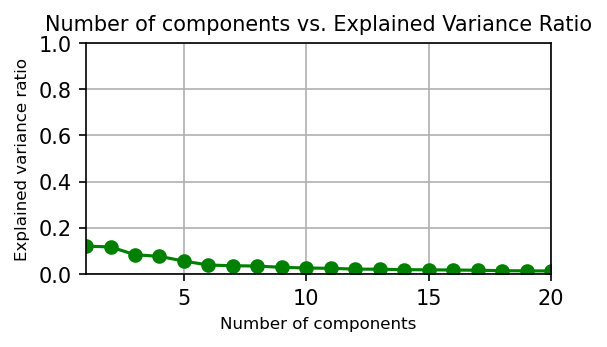

In [24]:
#plot the explained variance vs the number of components
plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(components,explained_variance_ratio,marker='o', color='green')

plt.xlabel('Number of components', size=8)
plt.xlim([1,len(components)])

plt.ylabel('Explained variance ratio', size=8)
plt.ylim([0,1])

#add title 
plt.title('Number of components vs. Explained Variance Ratio', size=10)


# Add figure caption
# plt.figtext(0.5, -0.3, "6 variables are needed to get te explained variance to zero", ha='center')

plt.show()

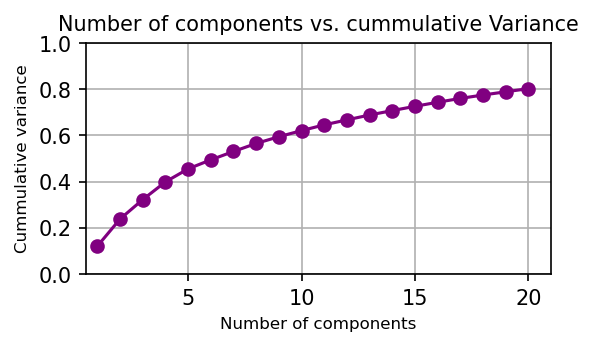

In [25]:
#plot the cummulative variance vs the number of components
plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(components,cumulative_variance,marker='o', color='purple')

plt.xlabel('Number of components', size=8)
plt.xlim([0.5,len(components)+1])

plt.ylabel('Cummulative variance', size=8)
plt.ylim([0,1])

plt.title('Number of components vs. cummulative Variance', size=10)


# Add figure caption
# plt.figtext(0.5, -0.3, "6 variables are needed to get the cummulative variance to at least 0.9", ha='center')

plt.show()

## PC1 and PC2  

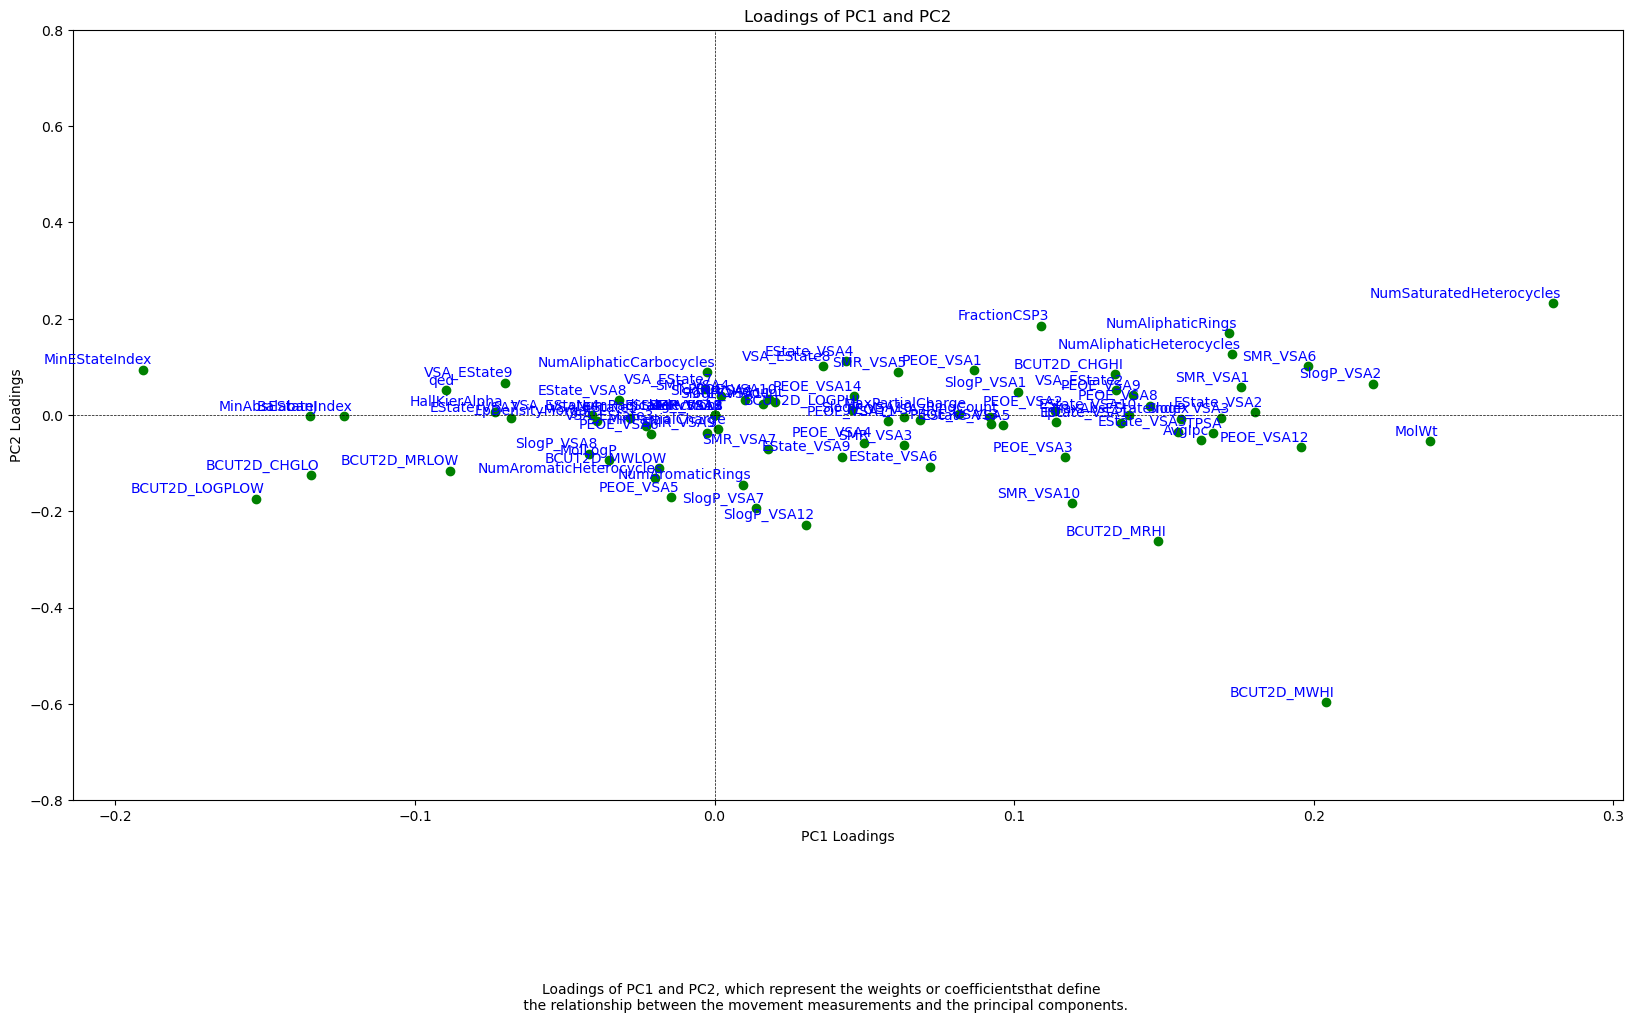

In [26]:
# Get loadings for PC1 and PC2
loadings_pc1 = pca_6.components_[0]
loadings_pc2 = pca_6.components_[1]

# Create scatter plot of loadings PC1 and PC2
plt.figure(figsize=(20,10))
plt.scatter(loadings_pc1, loadings_pc2,color='green')
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)  # Horizontal zero line
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)  # Vertical zero line
plt.xlabel('PC1 Loadings')
plt.ylabel('PC2 Loadings')
plt.ylim([-0.9,0.6])
plt.ylim([-0.8,0.8])
plt.title('Loadings of PC1 and PC2')

#display the variables corresponding to the points in the plot
variables = pca_df.columns
for i, variable in enumerate(variables):
    plt.annotate(variable, (loadings_pc1[i], loadings_pc2[i]), color='blue',xytext=(6, 2), textcoords='offset points', ha='right', va='bottom')


# Add figure caption
plt.figtext(0.5, -0.1, "Loadings of PC1 and PC2, which represent the weights or coefficients" 
            "that define \n the relationship between the movement measurements and the principal components.", ha='center')

plt.show()

In [27]:
variables

Index(['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed',
       'MolWt', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge',
       'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI',
       'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'HallKierAlpha', 'Ipc',
       'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13',
       'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5',
       'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1',
       'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6',
       'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',
       'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4',
       'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'EState_VSA1',
       'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3',
       'EState_VSA4', 'EState_VSA5', 'E

In [28]:
list_variables = []
weights = list(range(20,0,-1))
j = 0 
for pc in range(len(components)):
    loadings_pc = pca_6.components_[pc]
    i = 0
    weight = weights[j]
    j = j+1
    for value in loadings_pc:
        weighted_value = abs(value)*weight
        if weighted_value>4 and variables[i] not in list_variables:
            list_variables.append(variables[i])
        else:
            None
        i = i+1

print(list_variables)
        


['MolWt', 'BCUT2D_MWHI', 'SlogP_VSA2', 'NumSaturatedHeterocycles', 'BCUT2D_MRHI', 'SlogP_VSA12', 'HallKierAlpha', 'NumAromaticRings', 'MinEStateIndex', 'SlogP_VSA8', 'EState_VSA1', 'EState_VSA4', 'EState_VSA7', 'SlogP_VSA11', 'EState_VSA9', 'SMR_VSA7', 'PEOE_VSA2', 'NumAliphaticCarbocycles', 'PEOE_VSA8', 'PEOE_VSA12', 'SlogP_VSA7']


In [29]:
df_good_variables = pca_df[list_variables].copy()
df_good_variables.insert(0, 'SMILES', df_molecules['SMILES'])
df_good_variables

,SMILES,MolWt,BCUT2D_MWHI,SlogP_VSA2,NumSaturatedHeterocycles,BCUT2D_MRHI,SlogP_VSA12,HallKierAlpha,NumAromaticRings,MinEStateIndex,SlogP_VSA8,EState_VSA1,EState_VSA4,EState_VSA7,SlogP_VSA11,EState_VSA9,SMR_VSA7,PEOE_VSA2,NumAliphaticCarbocycles,PEOE_VSA8,PEOE_VSA12,SlogP_VSA7
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,0.688495,0.084394,0.647103,0.5,0.233313,0.000000,0.184564,0.6,0.732144,0.170668,0.118778,0.302955,0.642042,0.25,0.105513,0.479709,0.277948,0.0,0.641177,0.739676,0.0
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,0.501554,0.838092,0.263603,0.0,0.715999,0.253468,0.333893,0.8,0.821655,0.335008,0.000000,0.347615,0.428028,0.00,0.098392,0.624993,0.271356,0.0,0.122345,0.245987,0.0
4,CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21,0.591847,0.841296,0.323120,0.0,0.698454,0.488615,0.473154,0.6,0.359067,0.337814,0.197051,0.344362,0.483225,0.00,0.000000,0.410909,0.263765,0.0,0.441564,0.663378,0.0
5,CC1CCCCN1S(=O)(=O)c1ccc(NC(=O)c2cccc(-n3cnnn3)...,0.607114,0.841302,0.517485,0.5,0.691891,0.000000,0.325503,0.6,0.317093,0.170668,0.197051,0.242219,0.081420,0.00,0.000000,0.481790,0.138974,0.0,0.470626,0.417391,0.0
6,COCCN(C(=O)C(F)(F)F)C(C(=O)NC1CCCCC1)c1ccco1,0.496980,0.225887,0.495042,0.0,0.240332,0.000000,0.506711,0.2,0.089430,0.000000,0.601128,0.403699,0.000000,0.00,0.203905,0.192616,0.277948,0.5,0.388869,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,CCc1c(C)nc2ncnn2c1N1CCCC(C(=O)NCc2ccc3c(c2)OCO...,0.598297,0.095477,0.456579,0.5,0.215968,0.000000,0.283557,0.6,0.819211,0.173377,0.000000,0.753789,0.295434,0.50,0.211027,0.329694,0.138974,0.0,0.609898,0.528860,0.0
995,COc1ccc(N2C(=O)CC([NH2+]C3CC3)C2=O)cc1,0.244151,0.084368,0.312035,0.5,0.311446,0.000000,0.531879,0.2,0.797366,0.000000,0.000000,0.161480,0.062523,0.25,0.105513,0.193488,0.277948,0.5,0.253534,0.245987,0.0
997,NC(=O)Cn1cnc(-c2ccccc2)c1,0.112166,0.069088,0.155558,0.0,0.202220,0.000000,0.494966,0.4,0.777850,0.337814,0.000000,0.141558,0.356690,0.00,0.127717,0.341724,0.138974,0.0,0.232185,0.245987,0.0
998,Cc1cc(NC(=O)CSc2nc3c(c(=O)n(C)c(=O)n3C)n2C(C)C...,0.532279,0.838092,0.357259,0.0,0.716046,0.253468,0.374161,0.6,0.766362,0.335008,0.221148,0.057430,0.162841,0.00,0.100752,0.260461,0.542711,0.0,0.517341,0.245987,0.0


## Scores


In [30]:
#calculate the scores
scores = pca_6.transform(pca_df)

#see the scores of pc1 and pc2
scores_pc1 = scores[:, 0]
scores_pc2 = scores[:, 1]

#print(scores_pc1, scores_pc2)

In [31]:
#add the scores to the  dataframe and create a new dataframe

Pca_mols_df = pca_df.copy()

#see the scores for all the pcs
for pc in range(len(pca_6.components_)):
    scores_pc = scores[:, pc]
    Pca_mols_df['scores PC'+str(pc+1)] = scores_pc
    
Pca_mols_df['scores PC1'] = scores_pc1
Pca_mols_df['scores PC2'] = scores_pc2


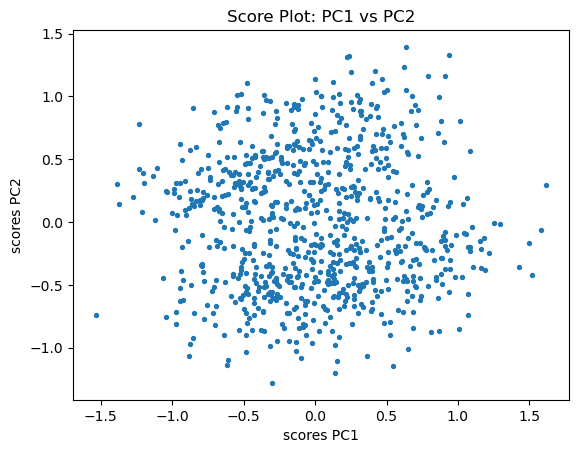

<Axes: xlabel='scores PC1', ylabel='scores PC2'>

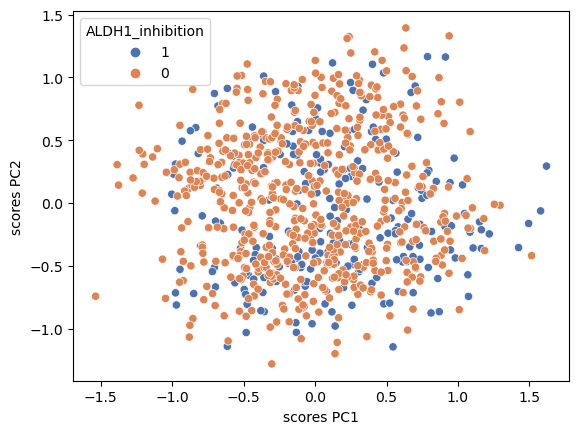

In [32]:
# Create scatter plot of scores
principal_1 = 'scores PC1'
principal_2 = 'scores PC2'
scores = pd.concat([df_molecules[['SMILES', 'ALDH1_inhibition']], Pca_mols_df[[principal_1,principal_2]]], axis=1, join = 'inner')
plt.scatter(scores_pc1, scores_pc2, s=8)
plt.xlabel(principal_1)
plt.ylabel(principal_2)
plt.title('Score Plot: PC1 vs PC2')
plt.show()
sns.scatterplot(data=scores, x=principal_1, y=principal_2, hue='ALDH1_inhibition' , palette = "deep")

# Machine Learning

In [33]:
#split the data in training and test set (80/20)
input_values = df_good_variables['SMILES']
output_values = df_good_variables.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(input_values, output_values, test_size=0.2, random_state=42)

# K-Means

### Making a k-means model

In [34]:
df_pca
 

array([[ 0.71868892,  0.52315357, -0.64441991, ...,  0.00615291,
        -0.02272003,  0.12971653],
       [-0.06873021, -0.6610568 , -0.33522403, ...,  0.14967802,
        -0.03635435, -0.13031567],
       [ 0.48158005, -0.80227497,  0.03766289, ..., -0.47115172,
         0.08436536, -0.21574464],
       ...,
       [-0.95208407,  0.2020814 , -0.18505484, ..., -0.07329704,
         0.18052663,  0.00958463],
       [ 0.40673537, -0.47842826, -0.28642104, ...,  0.427329  ,
        -0.18835955, -0.26191449],
       [-0.08410594, -0.81097562, -0.49770917, ...,  0.0145516 ,
         0.06885387,  0.03444973]])

In [35]:
#Making a k-means model with 3 clusters:

kmeans_3 = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
 )     

kmeans_3.fit(df_pca)
#fitting the model

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [36]:
#The SSE(sum of the squared error) for this model
kmeans_3.inertia_


1319.3668067839465

In [37]:
#The centers of the clusters
kmeans_3.cluster_centers_

array([[ 6.45985449e-01, -2.51328052e-01,  6.60762708e-02,
        -8.64348003e-02, -2.81575784e-02, -3.45751816e-02,
        -1.12916612e-01, -3.20733943e-03, -4.15614778e-02,
         4.31263768e-02, -8.33730115e-03,  9.71975980e-03,
        -2.36235437e-02,  1.26673345e-02,  1.73902196e-02,
        -1.72622747e-02,  1.77165170e-02, -2.75819811e-03,
         1.69433430e-02,  2.58363382e-02],
       [-2.34435800e-01, -4.64602119e-01,  2.39335534e-01,
         9.85074080e-02,  5.14425473e-02,  2.56629131e-04,
         8.68653916e-02,  2.35676018e-02, -9.50871075e-03,
        -2.93415374e-02, -2.24378674e-02, -4.08958006e-02,
         1.63951242e-02, -1.55952804e-03, -2.43873887e-02,
        -2.86502107e-03, -2.07543693e-02,  1.31838963e-02,
        -1.27763100e-02, -1.70677520e-02],
       [-1.92924249e-01,  4.81826876e-01, -2.12439432e-01,
        -2.33215397e-02, -2.17601021e-02,  1.93210890e-02,
         1.40846689e-04, -1.54380701e-02,  3.04097786e-02,
        -2.86046176e-03,  2.1

In [38]:
#Amount of iterations
kmeans_3.n_iter_ 

18

In [39]:
#Array which tells us which data belongs to which cluster
kmeans_3.labels_

array([2, 1, 0, 0, 2, 0, 1, 2, 2, 2, 1, 0, 1, 0, 1, 1, 2, 2, 2, 2, 0, 0,
       0, 1, 0, 0, 1, 2, 1, 1, 2, 0, 0, 2, 2, 0, 2, 1, 2, 0, 2, 0, 1, 0,
       1, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 1, 2, 1, 1, 0, 2, 1, 2,
       1, 2, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 2, 1, 2, 1, 2,
       1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1,
       0, 1, 2, 2, 0, 2, 0, 2, 2, 1, 2, 1, 1, 2, 0, 0, 0, 2, 2, 2, 1, 1,
       1, 1, 0, 0, 0, 2, 2, 0, 2, 2, 1, 0, 0, 1, 2, 2, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 2, 2, 2, 1, 2, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 0, 2, 1,
       0, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 0, 0, 2, 0, 1, 1, 1, 2, 0, 0, 2,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 0, 2, 2, 0, 1, 1, 0, 0,
       0, 0, 2, 1, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 0, 0, 2, 2, 1, 1, 0, 2, 0,
       1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 1, 0, 2, 2, 0,

### Determining the most optimal amount of clusters

In [40]:
#Making a new model try different amounts of clusters
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_pca)
    sse.append(kmeans.inertia_)

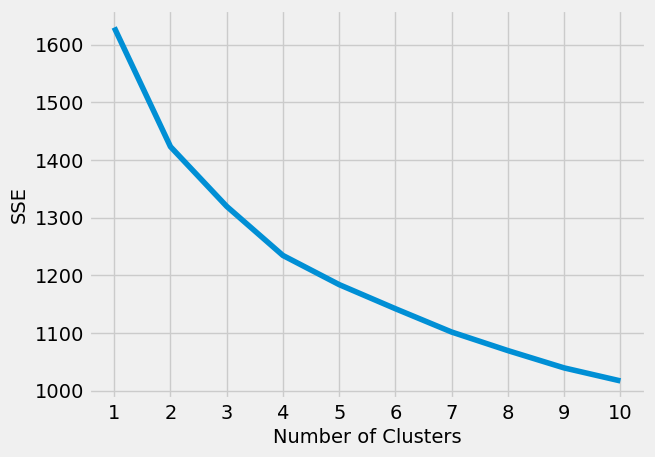

In [41]:
#plot the sse-values
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()         

In [42]:
#Using kneed to determine what the best amount of clusters is according to the graph
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

4

In [43]:
#another method to determine the best amount of clusters
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_pca)

    score =  silhouette_score(df_pca, kmeans.labels_)

    silhouette_coefficients.append(score)

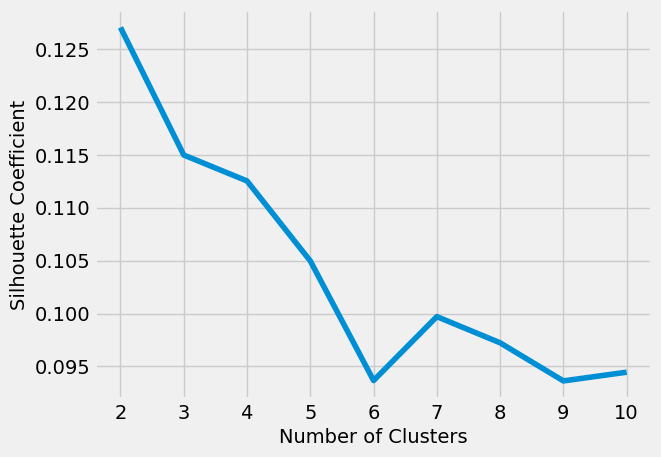

In [44]:
#Plotting the silhouette coefficients, the higher the better
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Plotting the data in clusters

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


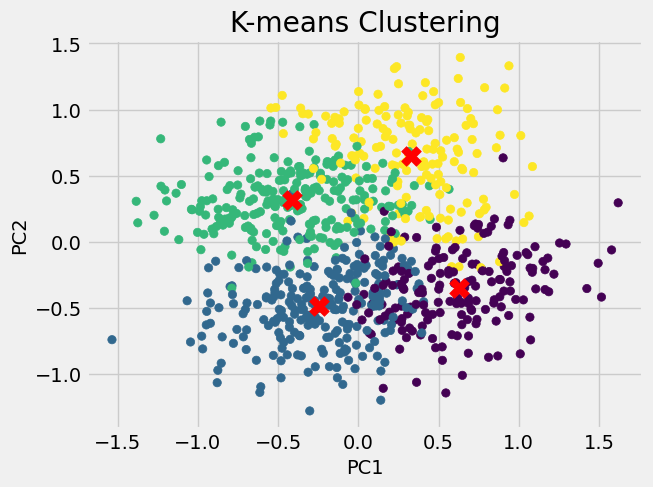

In [45]:
# Apply K-means clustering on the reduced data
k = 4  #Amount of clusters
kmeans = KMeans(n_clusters=k)
kmeans.fit(df_pca)

 

# Get the cluster labels and cluster centers
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

 

# Create a scatter plot of the reduced data with cluster labels
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', color='red', s=200)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering')
plt.show()

In [46]:
#Silhouette coefficient score for 4 clusters
score =  silhouette_score(df_pca, kmeans.labels_)
score

0.11278627459900793